<a href="https://colab.research.google.com/github/TK-Problem/Python-mokymai/blob/master/ML-AI/SD_infinite_zoom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Importuoti paketus
%%time
import os
import shutil
import imageio
import numpy as np

# ar išsaugoti į google drive?
gdrive = True #@param {type:"boolean"}
if gdrive:
  from google.colab import drive
drive.mount('/content/drive')
# look what library you have received
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Mounted at /content/drive
Tesla T4, 15360 MiB, 15101 MiB
CPU times: user 501 ms, sys: 105 ms, total: 605 ms
Wall time: 14.3 s


In [ ]:
#@title Sukurti AI aplinką
%%time
%pip install gradio > /dev/null 2>&1
%pip install -qq transformers scipy ftfy accelerate > /dev/null 2>&1
%pip install -qq --upgrade diffusers[torch]==0.16.1 > /dev/null 2>&1

import sys
sys.path.extend(['infinite-zoom-stable-diffusion/'])
from diffusers import StableDiffusionInpaintPipeline, EulerAncestralDiscreteScheduler
from PIL import Image
import torch
import time

CPU times: user 5.46 s, sys: 794 ms, total: 6.25 s
Wall time: 46.2 s


In [ ]:
#@title Pagalbinės funkcijos
def shrink_and_paste_on_blank_zoom_out(current_image, mask_width, mask_height):
  """
  Decreases size of current_image by mask_width pixels from each side,
  then adds a mask_width width transparent frame,
  so that the image the function returns is the same size as the input.
  :param current_image: input image to transform
  :param mask_width: width in pixels to shrink from each side
  :param mask_height: height in pixels to shrink from each side
  """

  # calculate new dimensions
  width, height = current_image.size
  new_width = width - 2 * mask_width
  new_height = height - 2 * mask_height

  # resize and paste onto blank image
  prev_image = current_image.resize((new_width, new_height))
  blank_image = Image.new("RGBA", (width, height), (0, 0, 0, 1))
  blank_image.paste(prev_image, (mask_width, mask_height))

  return blank_image

def write_video(file_path, frames, fps, reversed=True, start_frame_dupe_amount=15, last_frame_dupe_amount=30):
  """
  Writes frames to an mp4 video file
  :param file_path: Path to output video, must end with .mp4
  :param frames: List of PIL.Image objects
  :param fps: Desired frame rate
  :param reversed: if order of images to be reversed (default = True)
  """
  if reversed == True:
      frames = frames[::-1]

  # Drop missformed frames
  frames = [frame for frame in frames if frame.size == frames[0].size]

  # Create an imageio video writer, avoid block size of 512.
  writer = imageio.get_writer(file_path, fps=fps, macro_block_size=None)

  # Duplicate the start and end frames
  start_frames = [frames[0]] * start_frame_dupe_amount
  end_frames = [frames[-1]] * last_frame_dupe_amount

  # Write the duplicated frames to the video writer
  for frame in start_frames:
      # Convert PIL image to numpy array
      np_frame = np.array(frame)
      writer.append_data(np_frame)

  # Write the frames to the video writer
  for frame in frames:
      np_frame = np.array(frame)
      writer.append_data(np_frame)

  # Write the duplicated frames to the video writer
  for frame in  end_frames:
      np_frame = np.array(frame)
      writer.append_data(np_frame)

  # Close the video writer
  writer.close()

In [ ]:
#@title Pagrindiniai kintamieji
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
inpaint_model_list = [
    "stabilityai/stable-diffusion-2-inpainting",
    "runwayml/stable-diffusion-inpainting",
    "parlance/dreamlike-diffusion-1.0-inpainting",
    "ghunkins/stable-diffusion-liberty-inpainting",
    "ImNoOne/f222-inpainting-diffusers"
]
inpaint_model_list = [
    "parlance/dreamlike-diffusion-1.0-inpainting"
]

default_prompt_1 = "the most beautiful dreamlikeart 8k, trending, highly detailed hyper magical landscape in winter" #@param {type: "string"}
default_prompt_2 = "the most beautiful town dreamlikeart 8k, trending, highly detailed hyper magical landscape in spring" #@param {type: "string"}
default_prompt_3 = "the most beautiful dreamlikeart 8k, trending, highly detailed hyper magical landscape in summer" #@param {type: "string"}
default_prompt_4 = "the most beautiful village dreamlikeart 8k, trending, highly detailed hyper magical landscape in autumn" #@param {type: "string"}
step = 4 #@param {type: "integer"}
default_negative_prompt = "worst quality, low quality, (jpeg artifacts:1.4), (depth of field, bokeh, blurry, film grain, chromatic aberration, lens flare:1.0), title, logo, signature, pink" #@param {type: "string"}
num_interpol_frames = 24 #@param {type: "integer"}

In [ ]:
#@title Pagrindinė funkcija

def zoom(
    model_id,
    prompts_array,
    negative_prompt,
    num_outpainting_steps,
    guidance_scale,
    num_inference_steps,
    custom_init_image,
    output_path
):
    prompts = {}

    # create folder
    if os.path.exists(f"/content/drive/MyDrive/output/{output_path}") == False:
        os.makedirs(f"/content/drive/MyDrive/output/{output_path}")

    for x in prompts_array:
        try:
            key = int(x[0])
            value = str(x[1])
            prompts[key] = value
        except ValueError:
            pass
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
    )
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(
        pipe.scheduler.config)
    pipe = pipe.to("cuda")

    def no_check(images, **kwargs):
        return images, False
    pipe.safety_checker = no_check
    pipe.enable_attention_slicing()
    g_cuda = torch.Generator(device='cuda')

    # original
    height = 512 #@param {type: "integer"}
    width = 512 #@param {type: "integer"}

    current_image = Image.new(mode="RGBA", size=(width, height))
    mask_image = np.array(current_image)[:, :, 3]
    mask_image = Image.fromarray(255-mask_image).convert("RGB")
    current_image = current_image.convert("RGB")

    if (custom_init_image):
        current_image = custom_init_image.resize(
            (width, height), resample=Image.LANCZOS)
    else:
        init_images = pipe(prompt=prompts[min(k for k in prompts.keys() if k >= 0)],
                           negative_prompt=negative_prompt,
                           image=current_image,
                           guidance_scale=guidance_scale,
                           height=height,
                           width=width,
                           mask_image=mask_image,
                           num_inference_steps=num_inference_steps)[0]
        current_image = init_images[0]
    # mask_height = 128 #@param {type: "integer"}
    mask_width = 128 #@param {type: "integer"}

    all_frames = []
    all_frames.append(current_image)

    # return current_image
    for i in range(num_outpainting_steps):
        print('Outpaint step: ' + str(i+1) +
              ' / ' + str(num_outpainting_steps))

        prev_image_fix = current_image

        prev_image = shrink_and_paste_on_blank_zoom_out(current_image, mask_width, mask_width)

        # save image
        current_image.save(f"/content/drive/MyDrive/output/{output_path}/img_{str(i).zfill(4)}.png")
        current_image = prev_image

        # create mask (black image with white mask_width width edges)
        mask_image = np.array(current_image)[:, :, 3]
        mask_image = Image.fromarray(255-mask_image).convert("RGB")

        # inpainting step
        current_image = current_image.convert("RGB")
        images = pipe(prompt=prompts[max(k for k in prompts.keys() if k <= i)],
                      negative_prompt=negative_prompt,
                      image=current_image,
                      guidance_scale=guidance_scale,
                      height=height,
                      width=width,
                      # generator = g_cuda.manual_seed(seed),
                      mask_image=mask_image,
                      num_inference_steps=num_inference_steps)[0]
        current_image = images[0]
        current_image.paste(prev_image, mask=prev_image)

        # interpolation steps bewteen 2 inpainted images (=sequential zoom and crop)
        for j in range(num_interpol_frames - 1):
            interpol_image = current_image
            interpol_width = round(
                (1 - (1-2*mask_width/height)**(1-(j+1)/num_interpol_frames))*height/2
            )
            interpol_image = interpol_image.crop((interpol_width,
                                                  interpol_width,
                                                  width - interpol_width,
                                                  height - interpol_width))

            interpol_image = interpol_image.resize((height, width))

            # paste the higher resolution previous image in the middle to avoid drop in quality caused by zooming
            interpol_width2 = round(
                (1 - (height-2*mask_width) / (height-2*interpol_width)) / 2*height
            )
            prev_image_fix_crop = shrink_and_paste_on_blank_zoom_out(
                prev_image_fix, interpol_width2, interpol_width2)
            interpol_image.paste(prev_image_fix_crop, mask=prev_image_fix_crop)

            all_frames.append(interpol_image)

        all_frames.append(current_image)
        current_image.show()

    fps = 30
    save_path = "infinite_zoom.mp4"
    if gdrive:
       save_path = f"/content/drive/MyDrive/output/{output_path}/" + save_path
    start_frame_dupe_amount = 15
    last_frame_dupe_amount = 15

    write_video(save_path,
                all_frames,
                fps,
                False,
                start_frame_dupe_amount,
                last_frame_dupe_amount)

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

Outpaint step: 1 / 4


  0%|          | 0/50 [00:00<?, ?it/s]

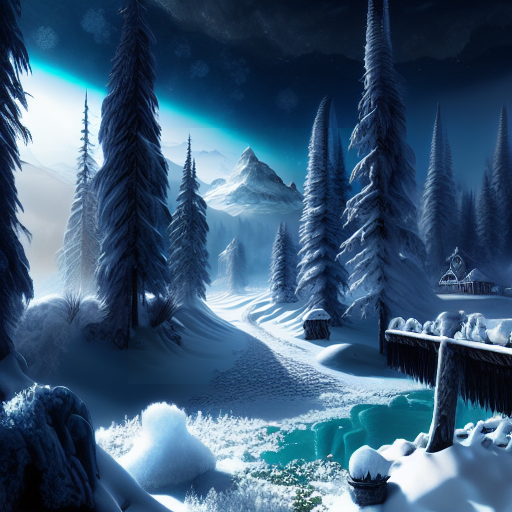

Outpaint step: 2 / 4


  0%|          | 0/50 [00:00<?, ?it/s]

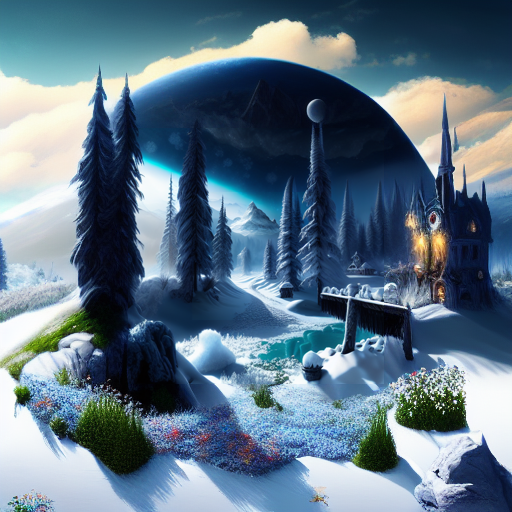

Outpaint step: 3 / 4


  0%|          | 0/50 [00:00<?, ?it/s]

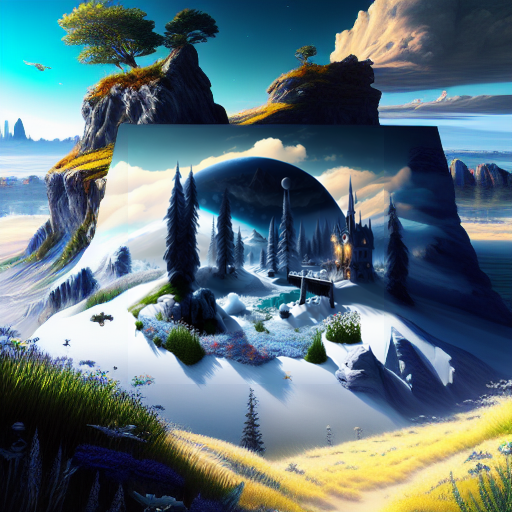

Outpaint step: 4 / 4


  0%|          | 0/50 [00:00<?, ?it/s]

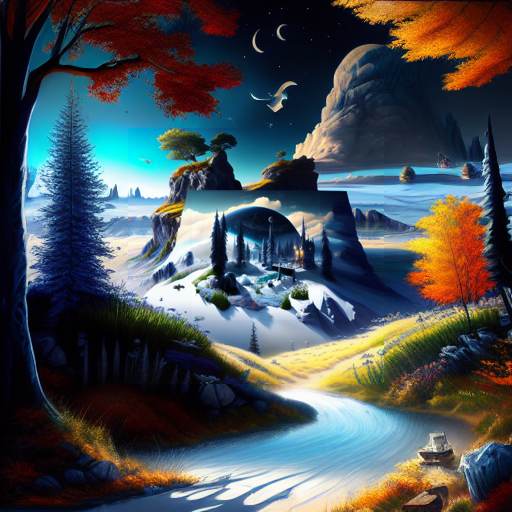

In [ ]:
#@title Paleisti script'ą
start_image = '' #@param {type: "string"}

if start_image == '':
  start_image = None
else:
  start_image = Image.open(start_image)
  start_image.convert("RGB")

# generate promts
prompts_array = list()
for i, _ in enumerate(range(step//4)):
  prompts_array.append([(i*4), default_prompt_1])
  prompts_array.append([(i*4)+1, default_prompt_2])
  prompts_array.append([(i*4)+2, default_prompt_3])
  prompts_array.append([(i*4)+3, default_prompt_4])

output_path = ''  #@param {type: "string"}
x = zoom(model_id="parlance/dreamlike-diffusion-1.0-inpainting",
    prompts_array=prompts_array,
    negative_prompt=default_negative_prompt,
    num_outpainting_steps=step,
    guidance_scale=7,
    num_inference_steps=50,
    custom_init_image=start_image,
    output_path=output_path)

## Užklausų (promts) pavyzdžiai

### Positive

* dreamlikeart beautiful mineral, crystals, ultra detailed, incredible lighting, 8k, unreal engine 5, 3d render
* dreamlikeart hyper realistic, lifelike texture, dramatic, lighting, unrealengine, trending on artstation, cinestill 800 tungsten, Style-Neeko
* dreamlikeart tree in a bottle, fluffy, realistic, photo, canon, dreamlike, art, colourful leaves and branches with flowers on top of its head. hyper detailed, photorealism by greg rutkowski
* dreamlikeart iridescent fantasy town
* dreamlikeart landscape in a bottle, fluffy, realistic, photo, canon, hyper detailed, photorealism by greg rutkowski
* clouds, machinery, gears, future, cyberpunk, no_humans, outdoors, rivers of blood, roads, landscapes, sky, sunset, trees, blood, horror, art by Katsuhiro Otomo
* the most beautiful dreamlikeart 8k, trending, highly detailed hyper realistic landscape with mountains

### Negative

* warped, grainy, bad quality, bad colors, transparent, signature, (((duplicate))), duplicates, repeat, text